# Генерация рецептов с помощью RNN


In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
PATH_TO_DATA='../content/gdrive/My Drive/datasets/'

In [2]:
# подключаем гугл диск на котором данные
from google.colab import drive
drive.mount ('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [3]:
!ls /content/gdrive/'My Drive'/datasets

author_quotes.txt		   r_n.txt
BIO_recipe_dataset.txt		   war_and_peace_bpe_train.txt
ingredients01.csv		   war_and_peace.txt
ncep				   wildfires_check.csv
nyt-ingredients-head.csv	   wildfires_train.csv
nyt-ingredients-snapshot-2015.csv  wildfires_train.gsheet
RAW_recipes.csv


In [4]:
data_df=pd.read_csv(PATH_TO_DATA+'ingredients01.csv',header=0)
data_df.head(10)

,"['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']"
0,"['prepared pizza crust', 'sausage patty', 'egg..."
1,"['ground beef', 'yellow onions', 'diced tomato..."
2,"['spreadable cheese with garlic and herbs', 'n..."
3,"['tomato juice', 'apple cider vinegar', 'sugar..."
4,"['milk', 'vanilla ice cream', 'frozen apple ju..."
5,"['fennel seeds', 'green olives', 'ripe olives'..."
6,"['pork spareribs', 'soy sauce', 'fresh garlic'..."
7,"['chocolate sandwich style cookies', 'chocolat..."
8,"['sugar', 'unsalted butter', 'bananas', 'eggs'..."
9,"['whole berry cranberry sauce', 'sour cream', ..."


In [5]:
data_df.columns=['Ingredients']

In [6]:
data_df.head()

,Ingredients
0,"['prepared pizza crust', 'sausage patty', 'egg..."
1,"['ground beef', 'yellow onions', 'diced tomato..."
2,"['spreadable cheese with garlic and herbs', 'n..."
3,"['tomato juice', 'apple cider vinegar', 'sugar..."
4,"['milk', 'vanilla ice cream', 'frozen apple ju..."


In [7]:
data_df.shape

(231636, 1)

In [8]:
names=data_df['Ingredients'][:100]

In [ ]:
#with open(PATH_TO_DATA+'r_n.txt') as input_file:
#    names = input_file.read()[:-1].split('\n')
#    names = [' ' + line for line in names]

In [9]:
names[:5]

0    ['prepared pizza crust', 'sausage patty', 'egg...
1    ['ground beef', 'yellow onions', 'diced tomato...
2    ['spreadable cheese with garlic and herbs', 'n...
3    ['tomato juice', 'apple cider vinegar', 'sugar...
4    ['milk', 'vanilla ice cream', 'frozen apple ju...
Name: Ingredients, dtype: object

Посмотрим на распределение длин рецептов:

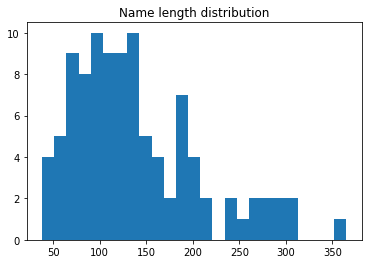

In [10]:
plt.title('Name length distribution')
plt.hist(list(map(len, names)), bins=25);

In [22]:
tokens_set=set()  #for tokens
good_data_list=[] #list for prepared data
for n in names:
  n=n[2:-2]
  temp=['START']  #THIS IS TECHNIKAL ELEMENT FOR MODEL TO START WITH
  temp.extend(list(map(str,n.split("', '"))))
  good_data_list.append(temp)


  #print(set(temp))
  tokens_set.update(set(temp))

In [23]:
good_data_list[:5]

[['START',
  'prepared pizza crust',
  'sausage patty',
  'eggs',
  'milk',
  'salt and pepper',
  'cheese'],
 ['START',
  'ground beef',
  'yellow onions',
  'diced tomatoes',
  'tomato paste',
  'tomato soup',
  'rotel tomatoes',
  'kidney beans',
  'water',
  'chili powder',
  'ground cumin',
  'salt',
  'lettuce',
  'cheddar cheese'],
 ['START',
  'spreadable cheese with garlic and herbs',
  'new potatoes',
  'shallots',
  'parsley',
  'tarragon',
  'olive oil',
  'red wine vinegar',
  'salt',
  'pepper',
  'red bell pepper',
  'yellow bell pepper'],
 ['START',
  'tomato juice',
  'apple cider vinegar',
  'sugar',
  'salt',
  'pepper',
  'clove oil',
  'cinnamon oil',
  'dry mustard'],
 ['START',
  'milk',
  'vanilla ice cream',
  'frozen apple juice concentrate',
  'apple']]

In [24]:
print(len(tokens_set),tokens_set)  #lets see the len of vocabulary and examples

431 {'parsley', 'beef consomme', 'ground pepper', 'sour cream', 'philadelphia cream cheese', 'onion', 'paprika', 'dry yeast', 'cilantro', 'picante sauce', 'cake flour', 'parsley flakes', 'whole berry cranberry sauce', 'egg substitute', 'green onion', 'cookie', 'broccoli', 'yellow cake mix', 'wood bethony', 'cooking oil', 'hot water', 'white pepper', 'scallions', 'chicken breasts', 'orange juice', 'margarine', 'strawberry', 'sambal oelek', 'yellow bell pepper', 'fresh ground black pepper', 'beef bouillon cube', 'fresh garlic', 'tomato puree', 'chicken bouillon cubes', 'nuts', 'toasted sesame oil', 'ground beef', 'hamburger buns', 'bacon', 'condensed cream of mushroom soup', 'white kidney beans', 'orange rind', 'scullcap herb', 'chicken rice soup', 'START', 'tarragon', 'tempeh', 'dried oregano', 'chat masala', 'peanuts', 'chopped tomato', 'tomato juice', 'good seasonings italian salad dressing mix', 'black beans', 'all-purpose flour', 'green pepper', 'kidney beans', 'chinese noodles', 'c

In [25]:
tokens=list(tokens_set)
print(tokens[:5])

['parsley', 'beef consomme', 'ground pepper', 'sour cream', 'philadelphia cream cheese']


# Препроцессинг

In [26]:
#all unique characters go here
#tokens = list(set(''.join(names)))
#tokens = list(set(names))
num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

num_tokens =  431


### Символы -> id

Создадим словарь < ингридиент > -> < id >

In [27]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}
#token_to_id={}
#cnt=0  #counter
#for elem in tokens:
#  token_to_id[elem]=cnt
#  cnt+=1

In [28]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems OK!")

Seems OK!


In [29]:
token_to_id['START']

44

In [30]:
def to_matrix(data, token_to_id, max_len=None, dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id['START']

    for i in range(len(data)):
        line_ix = [token_to_id[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

In [32]:
#Example: cast 4 names to matrices, pad with zeros
#print('\n'.join(names[::2000]))
#print(to_matrix(names[::2000], token_to_id))
#print(good_data_list)
print(to_matrix(good_data_list,token_to_id))

[[ 44 276 191 ...  44  44  44]
 [ 44  36 168 ...  44  44  44]
 [ 44 411 420 ...  44  44  44]
 ...
 [ 44 412   3 ...  44  44  44]
 [ 44 334 300 ...  44  44  44]
 [ 44 247 207 ...  44  44  44]]


# Рекуррентные нейронные сети

<img src="img/rnn.png" width=480>

In [33]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [34]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, variable containing vector of int64
        :param h_prev: previous rnn hidden states, variable containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        x_and_h = torch.cat([x_emb, h_prev], dim=1) #YOUR CODE HERE
        h_next = self.rnn_update(x_and_h) #YOUR CODE HERE
        
        h_next = F.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return Variable(torch.zeros(batch_size, self.num_units))

In [35]:
char_rnn = CharRNNCell()

### Тренировка сети, RNN loop

In [36]:
def rnn_loop(rnn, batch_index):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_index.size()
    hid_state = rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_index.transpose(0,1):
        hid_state, logp_next = rnn(x_t, hid_state)  
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

### Тренировка сети

In [37]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

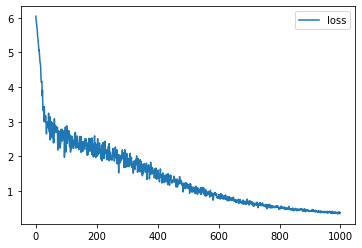

In [40]:
names=good_data_list
MAX_LENGTH = max(map(len, names))
for i in range(1000):
    batch_ix = to_matrix(sample(names, 32), token_to_id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))###YOUR CODE
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    # visualizing training process
    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

### RNN: генерация рецептов

In [46]:
def generate_sample(char_rnn, seed_phrase=['START'], max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [47]:
for _ in range(10):
    print(generate_sample(char_rnn))

STARTground venisonegg substitutenon-fat powdered milkwaterfresh breadcrumbground cuminoreganored pepper flakesSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTART
STARTground black pepperground gingerground corianderground cuminground turmericblack cuminbutterSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTART
STARTfrozen chopped spinacheggsground black pepperlasagna noodlemozzarella cheeseSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTART
STARTtomato juiceapple cider vinegarsoy saucehoneybrown sugargreen onionsbeef brothgreen onionolive oilbrothrolled oatscreamchili powderground cuminoreganonutssaltSTARTSTARTSTARTSTARTSTART
STARTshorteningicing sugarvanillaplain yogurtbaking powdersugareggssaltblack pepperSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTART
STARTfrozen french friesrice vinegarfrozen vegetablescream of mushroom soupblack cuminSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTAR

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [49]:
for _ in range(10):
    print(generate_sample(char_rnn, seed_phrase=['START','milk']))

STARTmilkvanilla ice creamfrozen apple juice concentrateappleSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTART
STARTmilkcornmealbananassausage pattyeggsvanillayogurtSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTART
STARTmilktomatoesfrozen apple juice concentrateappleSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTART
STARTmilkcheddar cheese soupfresh garlicfresh parsleylasagna noodlegarliccinnamonsoy sauceoreganovanillanutmegmilkpenne pastaSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTART
STARTmilktomatoesfrozen apple juice concentratetempehsaltdried thymeSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTART
STARTmilkvanilla ice creamfrozen apple juice concentrateappleSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTART
STARTmilkcream cheesepowdered sugarapplepearvanillaSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTSTARTST

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
